## **Imports**

In [1]:
import os
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import numpy as np

## **CT Scan Helper Functions**

In [4]:
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def window_image(img, window_center,window_width, intercept, slope):
    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    return img 

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

## **Preprocessing**

In [25]:
basedir = '/run/user/1002/gvfs/smb-share:server=sohn2020.local,share=research/NLST_032022'

manifest_dirs = filter(lambda dir: 'manifest' in dir, os.listdir(basedir))
manifest_metadata_dfs = []
for dir in manifest_dirs:
    folder = basedir + '/' + dir
    manifest_metadata_df = pd.read_csv((basedir + '/' + dir + '/metadata.csv'))
    
    manifest_metadata_df['File Location'] = manifest_metadata_df['File Location'].str.slice(start=1)
    manifest_metadata_df['File Location'] = (folder + manifest_metadata_df['File Location']).astype(str)

    manifest_metadata_dfs.append(manifest_metadata_df)

metadata = pd.concat(manifest_metadata_dfs)
metadata.rename(columns={'Subject ID': 'pid'}, inplace=True)
person_metadata = pd.read_csv('prsn.csv')
metadata = person_metadata.merge(metadata)

nlst_df = pd.DataFrame(columns=['pid', 'path', 'gender', 'weight'])

for i in range(len(metadata)):
    pid = metadata.iloc[i]['pid']
    weight = metadata.iloc[i]['weight']
    gender = metadata.iloc[i]['gender']
    if gender == 1:
        gender = 'Male'
    elif gender == 2:
        gender = 'Female'
    files = os.listdir(metadata.iloc[i]['File Location'])
    if len(files) > 2:
        path = folder + '/' + files[len(files) // 2]
        nlst_df.loc[len(nlst_df)] = {
            'pid': pid,
            'path': path,
            'gender': gender,
            'weight': weight,
        }
nlst_df.to_csv('nlst_raw.csv', index=False)

## **Path Verification**

In [84]:
nlst_raw_df = pd.read_csv('nlst_raw.csv')
processed_nlst_df = pd.DataFrame(columns=['pid', 'path', 'gender', 'weight'])
for i in range(len(nlst_df)):
    if i % 10000 == 0:
        print(i)
    if os.path.exists(nlst_df.iloc[i].path) and not nlst_df.iloc[i].weight.isna():
        processed_nlst_df.loc[len(processed_nlst_df)] = nlst_df.iloc[i]
processed_nlst_df.to_csv('nlst.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'nlst_raw.csv'

<AxesSubplot:>

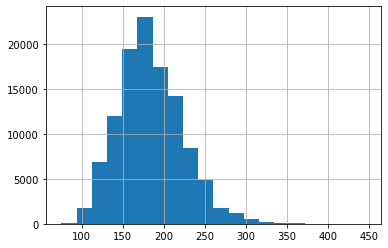

In [70]:
(nlst_df['weight']).hist(bins=20)

In [2]:
nlst_df = pd.read_csv('nlst.csv')

nlst_df = nlst_df[~nlst_df['weight'].isna()]

print('Number of Images: ', len(nlst_df))

pid_gender = list((nlst_df[['pid', 'gender']].value_counts()).index)
gender_counts = np.array(pid_gender)[:, 1]

pid_weight = list((nlst_df[['pid', 'weight']].value_counts()).index)
weight_counts = np.array(pid_weight)[:, 1]

female_count = len(gender_counts[gender_counts == 'Female'])
male_count = len(gender_counts[gender_counts == 'Male'])

less_than_150_count = len(weight_counts[weight_counts <= 150])
within_150_and_200_count = len(weight_counts[(150 < weight_counts) & (weight_counts < 200)])
greater_than_200_count = len(weight_counts[weight_counts >= 200])

retrieval_dataset_metadata = pd.DataFrame(
    columns = [
        'Task',
        'Number of Subjects',
        'Male', 'Female',
        '< 150',
        '150 < x < 200',
        '> 200'
    ]
)

retrieval_dataset_metadata.loc[0] = {
    'Task': 'Weight',
    'Number of Subjects': len(nlst_df.pid.unique()),
    'Male': male_count,
    'Female': female_count,
    '< 150': less_than_150_count,
    '150 < x < 200': within_150_and_200_count,
    '> 200': greater_than_200_count
}

retrieval_dataset_metadata

Number of Images:  111955


,Task,Number of Subjects,Male,Female,< 150,150 < x < 200,> 200
0,Weight,25354,14971,10383,5526,11619,8209


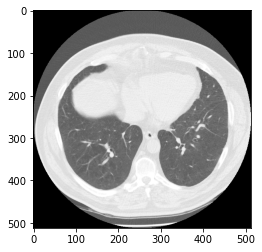

In [34]:
data = pydicom.dcmread(nlst_df.iloc[111125].path)
window_center, window_width, intercept, slope = get_windowing(data)
image_windowed = window_image(data.pixel_array, window_center, window_width, intercept, slope)
img = plt.imshow(image_windowed, cmap='Greys_r')